        E:\Data\FinalResults\Dsp\0846 - Position of Manifold Convergence for Route 2 3 5 6 is already existed!


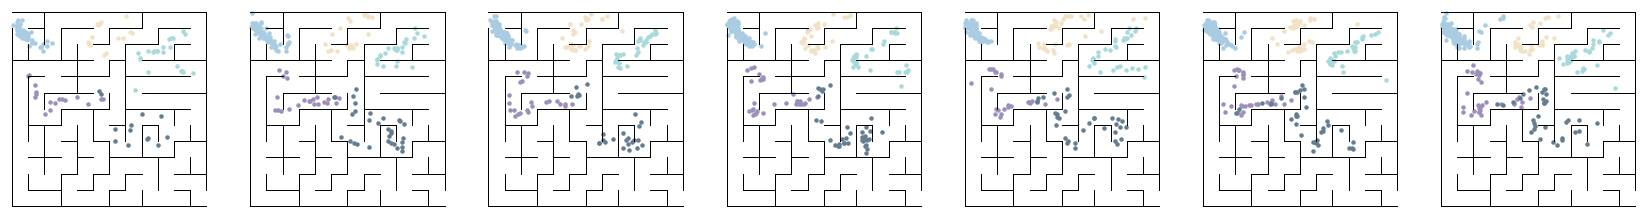

In [ ]:
from mylib.statistic_test import *

code_id = "0846 - Position of Manifold Convergence for Route 2 3 5 6"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

path = join(figpath, "Dsp", "0844 - Manifold of Initialization")

def calculate_in_manifold_position(mouse: int):
    with open(join(path, f"{mouse}.pkl"), 'rb') as handle:
        map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi, neural_traj = pickle.load(handle)
        
    old_pos_traj = spike_nodes_transform(pos_traj+1, 12)-1
    
    in_distances = np.sqrt(np.sum((centroid[old_pos_traj, :] - reduced_data[:, :3])**2, axis=1))
    dis_thres = raddi[old_pos_traj]
    
    in_manifolds = np.where(in_distances-dis_thres <= 0, 1, 0)
    in_manifolds = 1-map_clusters
    
    res = {
        "Position": [],
        "Route": [],
        "Session": [],
        "Speed": [],
        "Distances": []
    }
    
    D = GetDMatrices(1, 12)
    
    for i in range(len(beg)):        
        init_pos = np.where(in_manifolds[beg[i]:end[i]]==1)[0] + beg[i]
        
        if init_pos.shape[0] != 0:
            res['Session'].append(session_traj[beg[i]])
            res['Route'].append(route_traj[beg[i]])
            res['Position'].append(pos_traj[init_pos[0]]) 
            res['Speed'].append(speed_traj[init_pos[0]])
            res['Distances'].append(DSP_NRG[route_traj[beg[i]]][old_pos_traj[init_pos[0]]+1])
        
    return res

def hex_to_rgba(hex_color):
    """
    Convert a hex color (#RRGGBB or #RRGGBBAA) to RGBA format (0-255).
    """
    hex_color = hex_color.lstrip('#')  # Remove '#' if present
    if len(hex_color) == 6:
        r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
        a = 255  # Default alpha
    elif len(hex_color) == 8:
        r, g, b, a = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16), int(hex_color[6:8], 16)
    else:
        raise ValueError("Invalid hex color format. Use #RRGGBB or #RRGGBBAA.")
    return r, g, b, a

def hex_to_rgba_normalized(hex_color):
    """
    Convert a hex color (#RRGGBB or #RRGGBBAA) to RGBA format (0-1).
    """
    r, g, b, a = hex_to_rgba(hex_color)
    return np.array([r / 255, g / 255, b / 255, a / 255])

DSPPaletteRGBA = np.vstack([hex_to_rgba_normalized(c) for c in DSPPalette])

if exists(os.path.join(figdata, code_id+"  [First Switch Position].pkl")) == False:
    Data = {
        "Position": [],
        "Route": [],
        "Session": [],
        "Speed": [],
        "Distances": [],
        "MiceID": []
    }
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        res = calculate_in_manifold_position(mouse)
        for k in Data.keys():
            if k != 'MiceID':
                Data[k] += res[k]
            else:
                Data[k] += [mouse] * len(res['Position'])
    
    for k in Data.keys():
        Data[k] = np.array(Data[k], np.float64)
          
    with open(os.path.join(figdata, code_id+" [First Switch Position].pkl"), 'wb') as f:
        pickle.dump(Data, f)
        
    D = pd.DataFrame(Data)
    D.to_excel(os.path.join(figdata, code_id+" [First Switch Position].xlsx"), index=False)
    # Standard Deviation
    DisSTD = {
        "Session": [],
        "MiceID": [],
        "Speed": [],
        "Route": []
    }
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        for s in range(7):
            for r in range(7):
                idx = np.where((Data['Session'] == s)&(Data['Route'] == r)&(Data['MiceID'] == mouse))[0]
                if idx.shape[0] == 0:
                    continue
                DisSTD['Speed'].append(np.nanmean(Data['Speed'][idx]))
                DisSTD['MiceID'].append(mouse)
                DisSTD['Session'].append(s)
                DisSTD['Route'].append(r)
                
    for k in DisSTD.keys():
        DisSTD[k] = np.array(DisSTD[k])
        
    with open(join(figdata, code_id+" [First Switch Position STD].pkl"), 'wb') as f:
        pickle.dump(DisSTD, f)
else:
    with open(os.path.join(figdata, code_id+" [First Switch Position].pkl"), 'rb') as handle:
        Data = pickle.load(handle)
    
    with open(os.path.join(figdata, code_id+" [First Switch Position STD].pkl"), 'rb') as handle:
        DisSTD = pickle.load(handle)
    

x, y = Data['Position'] % 48 + np.random.rand(Data['Position'].shape[0])-0.5, Data['Position'] // 48 + np.random.rand(Data['Position'].shape[0])-0.5

fig, axes = plt.subplots(figsize = (21,3), ncols=7, nrows=1)

for i in range(7):
    for r in [0, 1, 2, 4, 5]:
        ax = Clear_Axes(axes[i])
        idx = np.where((Data['Route'] == r)&(Data['Session'] == i))[0]
        DrawMazeProfile(axes = ax, maze_type = 1, nx = 48, linewidth = 0.5, color = 'black')    
        ax.scatter(x[idx], y[idx], s = 5, color = DSPPalette[r], edgecolors=None)
        ax.set_aspect('equal')
        ax.invert_yaxis()
    

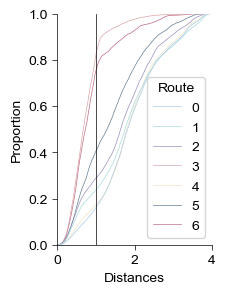

In [5]:
def Map2_in_manifold_proportion(mouse: int):
    with open(join(path, f"{mouse}.pkl"), 'rb') as handle:
        map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi, neural_traj = pickle.load(handle)
        
    ib_centroid = np.mean(reduced_data[np.where(map_clusters == 1)[0], :], axis=0)
    distances = np.sqrt(np.sum((reduced_data[np.where(map_clusters == 1)[0], :] - ib_centroid[np.newaxis, :])**2, axis=1))
    ib_raddi = np.percentile(distances, 90)
    ib_raddi95 = np.percentile(distances, 95)
    
    dist1 = np.sqrt(np.sum((reduced_data[np.where(route_traj == 0)[0], :] - ib_centroid[np.newaxis, :])**2, axis=1))/ib_raddi95
    dist2 = np.sqrt(np.sum((reduced_data[np.where(route_traj == 1)[0], :] - ib_centroid[np.newaxis, :])**2, axis=1))/ib_raddi95
    dist3 = np.sqrt(np.sum((reduced_data[np.where(route_traj == 2)[0], :] - ib_centroid[np.newaxis, :])**2, axis=1))/ib_raddi95
    dist4 = np.sqrt(np.sum((reduced_data[np.where(route_traj == 3)[0], :] - ib_centroid[np.newaxis, :])**2, axis=1))/ib_raddi95
    dist5 = np.sqrt(np.sum((reduced_data[np.where(route_traj == 4)[0], :] - ib_centroid[np.newaxis, :])**2, axis=1))/ib_raddi95
    dist6 = np.sqrt(np.sum((reduced_data[np.where(route_traj == 5)[0], :] - ib_centroid[np.newaxis, :])**2, axis=1))/ib_raddi95
    dist7 = np.sqrt(np.sum((reduced_data[np.where(route_traj == 6)[0], :] - ib_centroid[np.newaxis, :])**2, axis=1))/ib_raddi95
    
    return dist1, dist2, dist3, dist4, dist5, dist6, dist7
 

def Map1_in_manifold_proportion(mouse: int):
    with open(join(path, f"{mouse}.pkl"), 'rb') as handle:
        map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi, neural_traj = pickle.load(handle)
        
    ib_centroid = np.mean(reduced_data[np.where(map_clusters == 0)[0], :], axis=0)
    distances = np.sqrt(np.sum((reduced_data[np.where(map_clusters == 0)[0], :] - ib_centroid[np.newaxis, :])**2, axis=1))
    ib_raddi = np.percentile(distances, 90)
    ib_raddi95 = np.percentile(distances, 95)
    
    dist1 = np.sqrt(np.sum((reduced_data[np.where(route_traj == 0)[0], :] - ib_centroid[np.newaxis, :])**2, axis=1))/ib_raddi95
    dist2 = np.sqrt(np.sum((reduced_data[np.where(route_traj == 1)[0], :] - ib_centroid[np.newaxis, :])**2, axis=1))/ib_raddi95
    dist3 = np.sqrt(np.sum((reduced_data[np.where(route_traj == 2)[0], :] - ib_centroid[np.newaxis, :])**2, axis=1))/ib_raddi95
    dist4 = np.sqrt(np.sum((reduced_data[np.where(route_traj == 3)[0], :] - ib_centroid[np.newaxis, :])**2, axis=1))/ib_raddi95
    dist5 = np.sqrt(np.sum((reduced_data[np.where(route_traj == 4)[0], :] - ib_centroid[np.newaxis, :])**2, axis=1))/ib_raddi95
    dist6 = np.sqrt(np.sum((reduced_data[np.where(route_traj == 5)[0], :] - ib_centroid[np.newaxis, :])**2, axis=1))/ib_raddi95
    dist7 = np.sqrt(np.sum((reduced_data[np.where(route_traj == 6)[0], :] - ib_centroid[np.newaxis, :])**2, axis=1))/ib_raddi95
    
    return dist1, dist2, dist3, dist4, dist5, dist6, dist7

if exists(os.path.join(figdata, code_id+" [Map 2 Embedding].pkl")) == False:
    EData = {
        "Distances": [],
        "Route": [],
        "MiceID": []
    }
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        dist1, dist2, dist3, dist4, dist5, dist6, dist7 = Map2_in_manifold_proportion(mouse)
        EData['Distances'] += [dist1, dist2, dist3, dist4, dist5, dist6, dist7]
        EData['MiceID'].append(np.array([mouse] * (dist1.shape[0] + dist2.shape[0] + dist3.shape[0] + dist4.shape[0] + dist5.shape[0] + dist6.shape[0] + dist7.shape[0])))
        EData['Route'].append(np.array(
            [0] * dist1.shape[0] + 
            [1] * dist2.shape[0] + 
            [2] * dist3.shape[0] + 
            [3] * dist4.shape[0] + 
            [4] * dist5.shape[0] + 
            [5] * dist6.shape[0] + 
            [6] * dist7.shape[0]
        ))
    
    for k in EData.keys():
        EData[k] = np.concatenate(EData[k])
          
    with open(os.path.join(figdata, code_id+" [Map 2 Embedding].pkl"), 'wb') as f:
        pickle.dump(EData, f)
        
    D = pd.DataFrame(EData)
    D.to_excel(os.path.join(figdata, code_id+" [Map 2 Embedding].xlsx"), index=False)

else:
    with open(os.path.join(figdata, code_id+" [Map 2 Embedding].pkl"), 'rb') as handle:
        EData = pickle.load(handle)
        
        
fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.ecdfplot(
    x='Distances',
    data=EData,
    hue="Route",
    palette=DSPPalette,
    linewidth=0.5,
    ax=ax
)
ax.axvline(1, linewidth = 0.5, color = 'k')
ax.set_xlim(0, 4)
plt.savefig(join(loc, "Route 4, 7 in manifold.png"), dpi = 600)
plt.savefig(join(loc, "Route 4, 7 in manifold.svg"), dpi = 600)
plt.show()